In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from gensim import corpora, models, similarities, matutils

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%config Application.log_level="INFO"

data_dir = "/home/ubuntu/raw_data"

In [2]:
### Read in Title texts
raw_titles = [line.strip().replace(".", "").replace("$", "_$")
              for line in open(data_dir+"/titles", encoding="utf8")]
len(raw_titles)

112936

In [3]:
### Read in Plot texts
import re
plot_boundary = re.compile("<EOS>\\n") # "<EOS>\n" separates plots

raw_plots = open(data_dir+"/plots", encoding="utf8").read()
raw_plots = re.split(plot_boundary, raw_plots)
del raw_plots[-1] #deletes the empty string at the end of resulting list
len(raw_plots)

112936

In [4]:
plot_dict = dict(zip(raw_titles, raw_plots))
print(plot_dict["Animal Farm"][:100])

Old Major, the old boar on the Manor Farm, summons the animals on the farm together for a meeting, d


### NLP / Clustering Challenges


##### Challenge 1

Cluster sentences with K-means. If you have your own Fletcher text data, get sentences out and cluster them. If not, cluster the tweets you gathered during the last challenge set. For each cluster, print out the sentences, try to see how close the sentences are. Try different K values and try to find a K value that makes the most sense (the sentences look like they do form a meaningful cluster).

How do you deal with retweets (if you're clustering tweets)?

In [16]:
import random
# #get sentences to cluster
# raw_plots = open(data_dir+"/plots", encoding="utf8").read()
# sentences = re.split('\n', raw_plots)
# print("Number of all sentences: " + str(len(sentences)))

# ### Randomly select subsample of sentences
# sentences = random.sample(sentences, 100000)
# print("Number of selected sentences: " + str(len(sentences)))

# ### Randomly select subsample of plots
sampled_plots = random.sample(plot_dict.items(), 10000)
print("Number of selected plots: " + str(len(sampled_plots)))

Number of selected plots: 10000


In [19]:
sampled_plots[:10]

[('Companions in Nightmare',
  "Dr.\nLawrence Strelson (Melvyn Douglas) is a famous psychiatrist who conducts a group-therapy session with several high-priced professionals.\nIt turns out that one of the patients is a murderer; the truth will come out, and it will be a shocker.\nAmong the special guest suspects are Eric Nicholson (Gig Young), Carlotta Mauridge (Anne Baxter), Jeremy Siddack (Patrick O'Neal), Julie Klanton (Dana Wynter) and dr Neesden (Leslie Nielsen).\n"),
 ('Monkey Kingdom',
  "Maya is a toque macaque whose world is changed when her son Kip becomes part of her extended family.\nMaya’s family has its share of diverse personalities and she wishes her son to have the best advantages for advancing within the family's social strata.\nWhen their home is overrun by a neighboring tribe of monkeys, the family has to find a new home.\nMaya uses her inherent smarts to lead the family to new resources, but it develops that the entire group will have to cooperate in order to reclai

In [110]:
sample_size = 1000

plot_sample = raw_plots[:sample_size]
#plot_sample = sampled_plots

In [111]:
# Vectorize the text data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
#                                    stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
# count_vectorizer.fit(raw_plots)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
%time tfidf_vectorizer.fit(plot_sample)

vectorizer = tfidf_vectorizer

CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.55 s


In [112]:
# Create the term-document matrix
%time counts = vectorizer.transform(plot_sample)
counts.shape

CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.17 s


(1000, 335865)

In [113]:
from sklearn.cluster import KMeans, MiniBatchKMeans

num_clusters = 10
#km = MiniBatchKMeans(n_clusters=num_clusters, batch_size=1000)
km = KMeans(n_clusters=num_clusters)
%time km.fit(counts)

CPU times: user 25 s, sys: 304 ms, total: 25.3 s
Wall time: 16.2 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [114]:
terms = vectorizer.get_feature_names()

In [115]:
print(km.labels_.shape)
clusters = km.labels_.tolist()

(1000,)


In [116]:
labeled_dict = { 'cluster': clusters, 'title': raw_titles[:sample_size], 'plot': plot_sample }

frame = pd.DataFrame(labeled_dict, index = [clusters] , columns = ['cluster', 'title', 'plot'])

In [117]:
frame.head()
frame['cluster'].value_counts()

4    207
3    163
2    108
5     97
0     94
1     92
6     83
9     72
8     43
7     41
Name: cluster, dtype: int64

In [118]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
vocab_frame = pd.DataFrame(terms, index=terms)
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist()[:10]:
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'joe', b'film', b'cole', b'max', b'vincent', b'ash',

Cluster 0 titles: Army of Darkness, Citizen Kane, Destry Rides Again, Eyes Wide Shut, Evil Dead II, Fearless (1993 film), Hapworth 16, 1924, Johnny Got His Gun, Mulholland Drive (film), Meet the Feebles,

Cluster 1 words: b'george', b'carrie', b'billy', b'mr', b'julie', b'father',

Cluster 1 titles: Anyone Can Whistle, A Funny Thing Happened on the Way to the Forum, Carousel (musical), Four Weddings and a Funeral, My Fair Lady, The Spanish Inquisition (Monty Python), My Neighbor Totoro, Original Sin (2001 film), Pride and Prejudice, Raging Bull,

Cluster 2 words: b'mary', b'fred', b'man', b'al', b'home', b'father',

Cluster 2 titles: A Clockwork Orange (novel), Blade Runner, Blue Velvet (film), Barry Lyndon, Bank of China Tower (Hong Kong), The Cider House Rules, Day of the Tentacle, Death of a Hero, Escape from New York, The Trial,

Cluster 3 words: b'earth', b'planet', b'king', b'ship', b'

##### Challenge 2

Draw the inertia curve over different k values. (The sklearn KMeans class has an inertia_ attribute.)

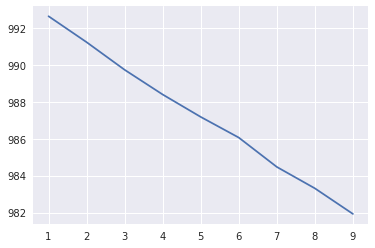

In [119]:
num_clusters = 10

inertias = []
for n in range(1, num_clusters):
    #km = MiniBatchKMeans(n_clusters=n, batch_size=1000)
    km = KMeans(n_clusters=n)
    km.fit(counts)
    inertias.append(km.inertia_)

plt.plot(range(1,num_clusters), inertias)

In [120]:
inertias

[992.6212648855328,
 991.21869488378,
 989.7242778167448,
 988.3884498853116,
 987.1765644102122,
 986.0588534792674,
 984.4722935272273,
 983.314262518235,
 981.9310119146555]

##### Challenge 3

__Let's name the clusters 1__

For each cluster, find the sentence closest to the centroid of the cluster.

(You can use [sklearn.metrics.pairwise_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances) or [scipy.spatial.distance](http://docs.scipy.org/doc/scipy/reference/spatial.distance.html) [check `pdist`, `cdist`, and `euclidean distance`] to find distances to the centroid). KMeans has a `cluster_centers_` attribute.

This sentence (closest to centroid) is now the name of the cluster. For each cluster, print the representative sentence, and print 'N people expressed a similar statement', or something like that relevant to your dataset. (This is very close to what amazon used to do in the reviews section.)

Find the biggest 3 clusters, and print their representative sentences. (This is close to what amazon is doing now in the reviews section, except they choose the sentence from the most helpful review instead of closest to center.)

In [121]:
num_clusters = 8
km = MiniBatchKMeans(n_clusters=num_clusters, batch_size=1000)
km.fit(counts)

clusters = km.labels_.tolist()

labeled_dict = { 'cluster': clusters, 'title': raw_titles[:sample_size], 'plot': plot_sample }

frame = pd.DataFrame(labeled_dict, index = [clusters] , columns = ['cluster', 'title', 'plot'])
terms = vectorizer.get_feature_names()

print("Top titles per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
vocab_frame = pd.DataFrame(terms, index=terms)
for i in range(num_clusters):
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist()[:5]:
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top titles per cluster:

Cluster 0 titles: Johnny Got His Gun, Neuromancer, The Big Lebowski, Midnight Cowboy, Everyone Says I Love You,

Cluster 1 titles: Animal Farm, A Clockwork Orange (novel), The Plague, Actaeon, A Fire Upon the Deep,

Cluster 2 titles: Citizen Kane, Show Me Love (film), The Spanish Inquisition (Monty Python), The Parent Trap (1961 film), How Green Was My Valley,

Cluster 3 titles: Army of Darkness, Blazing Saddles, Blue Velvet (film), Batman (1989 film), Batman (1966 film),

Cluster 4 titles: Doraemon, Heretic II, Icehenge, Return to Castle Wolfenstein, Sailor Moon,

Cluster 5 titles: Bank of China Tower (Hong Kong), The Trial, Fearless (1993 film), Adventures of Huckleberry Finn, Into the Woods,

Cluster 6 titles: Carousel (musical), Gaudy Night, Miss Congeniality (film), Pride and Prejudice, The Rocky Horror Picture Show,

Cluster 7 titles: Blade Runner, Blade Runner 2: The Edge of Human, Carmilla, Dressed to Kill (1980 film), Mulholland Drive (film),





In [122]:
frame['cluster'].value_counts()

1    632
3    106
5     78
6     52
4     47
0     39
2     25
7     21
Name: cluster, dtype: int64

In [123]:
groupby_cluster = frame['plot'].groupby(frame['cluster'])

cluster_concat_df = groupby_cluster.apply(lambda x: " ".join(x))
cluster_concat_df

cluster
0    Joe Bonham, a young American soldier serving i...
1    Old Major, the old boar on the Manor Farm, sum...
2    In a mansion in Xanadu, a vast palatial estate...
3    Being transported to the Middle Ages, Ash Will...
4    Nobita is a young boy who suffers from poor gr...
5    The site on which the building is constructed ...
6    Two young female millworkers in 1873 Maine vis...
7    In Los Angeles in November 2019, ex-police off...
Name: plot, dtype: object

##### Challenge 4

__Let's name the clusters 2__

Calculate the tf-idf of each word in each cluster (think of all sentences of a cluster together as a document). Represent each cluster with the top 1, or top 2 or... to 5 tf-idf words. For each cluster, print the name (keywords) of the cluster, and "N statements" in the cluster (N is the size of the cluster)

In [124]:
cluster_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
cluster_tfidf_vectorizer.fit(cluster_concat_df)

vectorizer = cluster_tfidf_vectorizer

In [125]:
terms = vectorizer.get_feature_names()

In [132]:
import math
from textblob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

"""
tf(word, blob) computes "term frequency" which is the number of times a word appears in a document blob, normalized by dividing by the total number of words in blob. We use TextBlob for breaking up the text into words and getting the word counts.

n_containing(word, bloblist) returns the number of documents containing word. A generator expression is passed to the sum() function.

idf(word, bloblist) computes "inverse document frequency" which measures how common a word is among all documents in bloblist. The more common a word is, the lower its idf. We take the ratio of the total number of documents to the number of documents containing word, then take the log of that. Add 1 to the divisor to prevent division by zero.

tfidf(word, blob, bloblist) computes the TF-IDF score. It is simply the product of tf and idf.
"""

In [ ]:
bloblist = cluster_concat_df.apply(tb)
for i, blob in enumerate(bloblist):
    print("Top words in cluster {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:3]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in document 1
	Word: Dude, TF-IDF: 0.00291
	Word: Case, TF-IDF: 0.00213
	Word: McCauley, TF-IDF: 0.00183
Top words in document 2


KeyboardInterrupt: 

##### Challenge 5

__Let's name the clusters 3__

Same as the previous challenge, but this time, calculate tf-idf only for nouns (NN tag) and build keyword(s) with nouns. (This is close to what amazon switched to last year, before settling into the current design). (They would show five nouns, you would click on one and it would show sentences - linked to the reviews- that were related to that noun.)

##### Challenge 6

Cluster the same data with [MiniBatchKMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html). MiniBatchKMeans is a fast way to apply K-means to large data without much loss -- The results are very similar. Instead of using EVERY single point to find the new place of the centroid, MiniBatch just randomly samples a small number (like 100) in the cluster to calculate the new center. Since this is usually very close to the actual center, the algorithm gets there much faster. Try it and compare the results. ([Example on two-feature data](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html))

##### Challenge 7

Switch the __init__ parameter to "random" (instead of the default kmeans++) and plot the inertia curve for each of the __n_init__ values for K-Means: 1, 2, 3, 10 (n_init is the number of different runs to try with different random initializations).

##### Challenge 8

Download [this dataset on the purchase stats from clients of a wholesale distributor](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). Cluster the clients based on their annual spending features (fresh, milk, grocery, frozen, detergents_paper, delicatessen). Remember to scale the features before clustering. After finding a reasonable amount of clusters, for EACH cluster, plot the histogram for every single feature: FRESH, MILK, GROCERY, FROZEN, DETERGENTS_PAPER, DELICATESSEN, CHANNEL, REGION. Is there a natural way to characterize each cluster? How would you describe each cluster to the wholesale distributor if you were working for them?

#### Clustering Extensions (Optional)

Use the same code for your previous clustering challenges.

Repeat each challenge (except the inertia curves, since only the KMeans implementation gives a quick way of calculating that.) However, this time, try (both) Agglomerative Clustering and DBSCAN instead of KMeans.

For text clustering, use cosine distance.